In [20]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import tqdm

In [21]:
def one_hot(labels):
    """
    标签one-hot处理
    """
    num = len(labels)
    result = np.zeros((num, 10))
    for i in range(num):
        result[i][labels[i]] = 1
    return result

'''
激活函数
'''
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
def sigmoid_grad(z):
    return sigmoid(z)*(1-sigmoid(z))

def relu(z):
    return np.maximum(0, z)
def relu_grad(z):
    return np.where(z>=0,1,0)

def tanh(z):
    return (np.exp(z) - np.exp(-z))/(np.exp(-z) + np.exp(z))
def tanh_grad(z):
    return 1.0 - tanh(z) * tanh(z)

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x)  # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))

"""
损失函数
"""
def mean_squared_error(y_pre, y):
    """
    均方误差
    """
    return 0.5 * np.sum((y_pre-y)**2)

def cross_entropy_error(y_pre, y):
    """
    与softmax分类器对应的交叉熵作为损失函数
    """
    y = np.array(y)
    y_pre = np.array(y_pre)
    if y_pre.ndim == 1:
        y = y.reshape(1, y.size)
        y_pre = y_pre.reshape(1, y_pre.size)

    # 监督数据是one-hot时，转为标签的索引值
    if y.size == y_pre.size:
        y = y.argmax(axis=1)

    batch_size = y_pre.shape[0]
    return -np.sum(np.log(y_pre[np.arange(batch_size), y] + 1e-7)) / batch_size

In [22]:
class Net(object):
    '''
    神经网络，含输入、隐藏、输出3层
    参数：
        l0, l1, l2：各层节点个数
        self.lr：SGD中的learning rate，学习率
        self.lamda：L2正则化项
    '''
    def __init__(self, l0, l1, l2, lr=0.25, lamda=0.025):
        self.lr = lr
        self.lamda = lamda
        # self.w1 = np.random.randn(l0, l1) * 0.01        # l0 x l1
        # self.w2 = np.random.randn(l1, l2) * 0.01        # l1 x l2
        # self.w3 = np.random.randn(l2, l3) * 0.01
        # self.b3 = np.random.randn(l3) * 0.01
        self.w1 = np.random.normal(loc=0, scale=1, size=(l0, l1)) * 0.01
        self.b1 = np.zeros(l1)
        self.w2 = np.random.normal(loc=0, scale=1, size=(l1, l2)) * 0.01
        self.b2 = np.zeros(l2)

    
    def forward_prop(self, X, Y, m):
        """
        前向传播
        参数：
            X,Y：
            m：batch size
        """
        self.X = np.array(X)                                    # m x l0(=784)
        self.z1 = np.dot(X, self.w1) + self.b1                  # m x l1
        self.a1 = tanh(self.z1)                              # m x l1
        self.z2 = np.dot(self.a1, self.w2) + self.b2            # m x 12(=10)
        self.a2 = softmax(self.z2)                              # 网络预测结果
        cost = cross_entropy_error(self.a2, Y)                # 均方差
        
        return cost, self.a2

    def backward_prop(self,y,m):
        """
        反向传播，用于求C对w,b的偏导
        注意损失函数含L2正则化项
        """
        d2 = (self.a2-y)
        #d2 = (self.a2-y) * tanh_grad(self.z2)                    # 损失函数对应
        dw2 = np.dot(self.a1.T, d2)/m + self.lamda*self.w2/m
        db2 = np.sum(d2, axis=0)/m
        d1 = np.dot(d2, self.w2.T) * tanh_grad(self.z1)
        dw1 = np.dot(self.X.T, d1)/m + self.lamda*self.w1/m       # l784 x l1
        db1 = np.sum(d1, axis=0)/m                                # l1
        
        # 根据偏导，更新参数值
        self.w2 -= self.lr*dw2
        self.b2 -= self.lr*db2
        self.w1 -= self.lr*dw1
        self.b1 -= self.lr*db1
    
    def SGD(self,data,batch_size=10,epochs=5):
        """
        随机梯度下降法：每次把全部样本点抽中算一次epoch
        data：一个元素为(x, y)元祖形式的列表
        :param epochs: 训练轮次
        :param mini_batch_size: 小批量训练样本数据集大小
        :param eta: 学习率
        """
        n = len(data)                    # data中总样本数量
        acc_list,loss_list = [],[]
        tmp = 0
        for j in range(epochs):
            random.shuffle(data)         # 打乱顺序
            img,label = zip(*data)
            if j%3==0:
                nn.lr_descent(j)
            for i in tqdm.tqdm(range(0,n,batch_size), position=0, desc=f'Epoch {j+1}/{epochs}', ncols=30):
                X = img[i: i+batch_size]
                Y = label[i: i+batch_size]
                loss, result = nn.forward_prop(X, Y, batch_size)
                if ((i+1)//batch_size)%50==0:
                    result = np.argmax(result, axis=1)
                    acc = np.sum(result==np.argmax(Y,axis=1))
                    acc_list.append(acc/float(batch_size))
                    loss_list.append(loss+self.lamda*np.linalg.norm(self.w2,ord=2)+self.lamda*np.linalg.norm(self.w1,ord=2))#
                nn.backward_prop(Y,batch_size)
        # 绘制精确率、损失曲线
        self.acc_loss_plot(acc_list, loss_list, batch_size, epochs)
        # 储存参数
        np.savez("data.npz", w1=nn.w1, b1=nn.b1, w2=nn.w2, b2=nn.b2, lr=nn.lr, lamda=nn.lamda, l1=len(nn.b1))
    

    def lr_descent(self,epoch,rate=0.75):
        """
        学习率下降策略
        """
        self.lr = self.lr*rate
    
    def acc_loss_plot(self, acc_list, loss_list, batch_size, epochs):
        itr_per_epochs = 60000//batch_size//50
        x1 = np.arange(len(acc_list))
        x2 = range(0,len(acc_list),itr_per_epochs)
        
        plt.subplots(1,2)
        # 精确度曲线绘制
        #fig = plt.figure()
        plt.subplot(1,2,1)
        plt.plot(x1, acc_list)
        plt.xticks(x2,range(epochs))
        plt.ylim(0.0,1.0)
        plt.title('Training Accuracy')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        #plt.figure(figsize=(2, 2))
        
        # 损失曲线绘制
        plt.subplot(1,2,2)
        plt.plot(x1, loss_list)
        plt.xticks(x2,range(epochs))
        plt.title('Training Loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        #plt.figure(figsize=(2, 2))
        
        plt.tight_layout()
        plt.savefig('savefig_example.png', bbox_inches='tight')
        plt.show()

In [23]:
#读取MNIST数据

label_t10k_path = './MNIST/t10k-labels.idx1-ubyte'
label_train_path = './MNIST/train-labels.idx1-ubyte'
img_t10k_path = './MNIST/t10k-images.idx3-ubyte'
img_train_path = './MNIST/train-images.idx3-ubyte'

#'rb'以二进制格式打开一个文件用于只读
with open(label_t10k_path, 'rb') as label_obj:
    label_t10k = np.frombuffer(label_obj.read(), dtype=np.uint8, offset=8)
    m_t10k = len(label_t10k)
    label_t10k = np.asarray(label_t10k).reshape(m_t10k, 1) # 10000 x 1
    label_t10k = one_hot(label_t10k) # one-hot 10000 x 10
with open(img_t10k_path, 'rb') as img_obj:
    img_t10k = np.frombuffer(img_obj.read(), dtype=np.uint8, offset=16)
    img_t10k = np.asarray(img_t10k).reshape(m_t10k, 784) / 255 # 10000 x 784

with open(label_train_path, 'rb') as label_obj:
    label_train = np.frombuffer(label_obj.read(), dtype=np.uint8, offset=8)
    m_train = len(label_train)
    label_train = np.asarray(label_train).reshape(m_train, 1) # 60000 x 1
    label_train = one_hot(label_train) # one-hot 60000 x 10
with open(img_train_path, 'rb') as img_obj:
    img_train = np.frombuffer(img_obj.read(), dtype=np.uint8, offset=16)
    img_train = np.asarray(img_train).reshape(m_train, 784) / 255 # 60000 x 784

training_data = list(zip(img_train, label_train))
validation_data = list(zip(img_t10k, label_t10k))
# 可用X,Y = zip(*training_data)解压

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


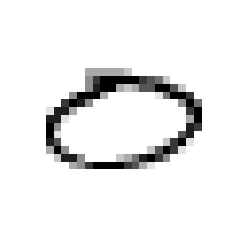

In [24]:
# 绘制手写图像
random.shuffle(training_data)
x,y=zip(*training_data)
print(y[200])
some_digit = x[200]
some_digit_image = some_digit.reshape(28,28)
 
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis('off')
plt.show()

Epoch 11/11: 100%|█| 600/600 [00:03<00:00, 166.83it/s]


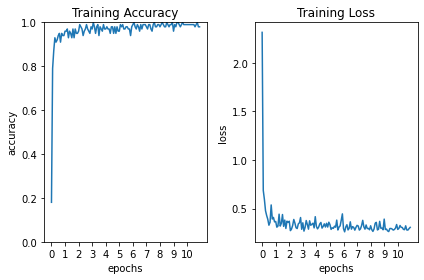

In [25]:
input_nodes = 784
hidden_nodes = 64
output_nodes = 10
lr = 1.0

# 训练模型
# nn = Net(input_nodes, hidden_nodes, output_nodes, lr)
# nn.SGD(training_data, batch_size=100, epochs=11)

In [27]:
# 测试模型
r = np.load("data.npz")
r = np.load("best_data.npz")   # 最佳模型参数
hidden_nodes = r["l1"]
nn = Net(input_nodes, hidden_nodes, output_nodes, lr)
nn.w1 = r["w1"]
nn.b1 = r["b1"]
nn.w2 = r["w2"]
nn.b2 = r["b2"]
nn.lr = r["lr"]
nn.lamda = r["lamda"]

_, result = nn.forward_prop(img_t10k, label_t10k, m=10000)
result = np.argmax(result, axis=1)
true = np.argmax(label_t10k, axis=1)
precison = np.sum(result==true) / 10000
print("Precison:", precison)

Precison: 0.9765


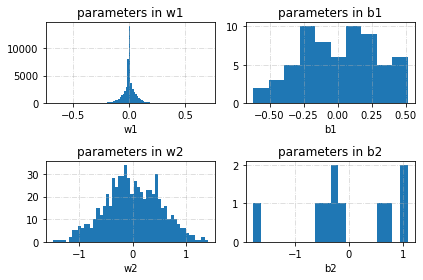

In [29]:
plt.subplot(2,2,1)
plt.hist([b for a in r["w1"] for b in a],bins=100)  #频率直方图
plt.grid(alpha=0.5,linestyle='-.') #网格线
plt.xlabel('w1')  
plt.title(r'parameters in w1') 

plt.subplot(2,2,2)
plt.hist(r["b1"],bins=10)  #频率直方图
plt.grid(alpha=0.5,linestyle='-.') #网格线
plt.xlabel('b1')  
plt.title(r'parameters in b1') 

plt.subplot(2,2,3)
plt.hist([b for a in r["w2"] for b in a],bins=50)  #频率直方图
plt.grid(alpha=0.5,linestyle='-.') #网格线
plt.xlabel('w2')  
plt.title(r'parameters in w2') 

plt.subplot(2,2,4)
plt.hist(r["b2"],bins=20)  #频率直方图
plt.grid(alpha=0.5,linestyle='-.') #网格线
plt.xlabel('b2')  
plt.title(r'parameters in b2') 

plt.tight_layout()
plt.show()